<a href="https://colab.research.google.com/github/charlesreid1/dib-deep-chem/blob/master/deepchem_ch6_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

Start by importing tensorflow and seeing if there is a GPU device available.

In [0]:
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')

Install miniconda, then install prerequisites for deepchem:

In [0]:
%%bash
if [ -f /usr/local/bin/conda ]; then
  echo 'conda installed already!'
else
  echo 'conda not installed; going for it!'
  curl -O -L https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
fi

# install important things
conda install -y --prefix /usr/local -c conda-forge rdkit joblib simdna

conda installed already!
Solving environment: ...working... done

# All requested packages already installed.



Now set the `$PYTHONPATH` variable so that the notebook can access all the packages we installed above:

In [0]:
import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':/usr/local/lib/python3.6/site-packages:/usr/local/lib/python3.7/site-packages'

Install [PBR (python build reasonableness)](https://launchpad.net/pbr):

In [0]:
!pip install pbr

Install deepchem from source:

In [0]:
%%bash
# now install deepchem from source

if [ \! -d deepchem-repo ]; then
  git clone https://github.com/deepchem/deepchem.git deepchem-repo
fi
cd deepchem-repo && python setup.py install

running install
[pbr] Writing ChangeLog
[pbr] Generating ChangeLog
[pbr] ChangeLog complete (0.1s)
[pbr] Generating AUTHORS
[pbr] AUTHORS complete (0.1s)
running build
running build_py
running egg_info
writing deepchem.egg-info/PKG-INFO
writing dependency_links to deepchem.egg-info/dependency_links.txt
writing top-level names to deepchem.egg-info/top_level.txt
writing pbr to deepchem.egg-info/pbr.json
[pbr] Processing SOURCES.txt
[pbr] In git context, generating filelist from git
reading manifest template 'MANIFEST.in'
writing manifest file 'deepchem.egg-info/SOURCES.txt'
running install_lib
running install_egg_info
removing '/usr/local/lib/python3.7/site-packages/deepchem-2.2.1.dev49-py3.7.egg-info' (and everything under it)
Copying deepchem.egg-info to /usr/local/lib/python3.7/site-packages/deepchem-2.2.1.dev49-py3.7.egg-info
running install_scripts


/usr/local/lib/python3.7/site-packages/pbr/packaging.py:410: EasyInstallDeprecationWarning: Use get_header
  header = easy_install.get_script_header("", executable, is_wininst)


Add the site packages location to the system path:

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append('/usr/local/lib/python3.6/site-packages')

## Import Stuff

In [0]:
# also import cool stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Transcription Factor Example



## Overview

This example will use a data set about a transcription factor called JUND. The data set used in this example comes from the human chromosome 22 (the smallest human chromosome). It is 50 Mbp.

The chromosome is broken into short segments of 101 base pairs.

One hot encoding is used to represent the sequences (i.e., each base pair is turned into a vector of 0s and 1s).

In [0]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

fatal: destination path 'DeepLearningLifeSciences' already exists and is not an empty directory.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

## Neural Network Architecture

Beacuse we are dealing with a 1D sequence of data, we use a convolutional neural network that performs the convolution in 1 dimension (rather than 2 dimensions usually used with image data).

Import necessary modules to build our neural network model:

In [0]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import deepchem.models.tensorgraph.layers as layers

Now we create the ingredients required by our model.

The model is a TensorGraph model. We assemble the model layer by layer.

The model must have labels (names for columns of data) and weights (for the input data).

In [0]:
# Create model:
model = dc.models.TensorGraph(batch_size=1000)
features = layers.Feature(shape=(None, 101, 4))
labels = layers.Label(shape=(None, 1))
weights = layers.Weights(shape=(None, 1))

Convolution neural networks usually follow a scheme that includes the following layers in order:

The following neural network layer combo composes a single convolution layer:

* Convolution (multiple convolution layers to deal with different portions of the data, e.g., 2 convolution layers each handing half the image)
* Pool (combine convolutions)
* Dropout (filter information - optional)

These layers are repeated one or more times. Once the convolution layers have been implemented, the following layers are added to the end to convert the neural network's output into a usable classification/prediction:

* Flatten (change dimensionality)
* Dense
* Dropout (filter information - optional)
* Dense

In [0]:
# Set model architecture:

# Three convolutional layers with identical parameters
prev = features
convolution_window = 10
for i in range(3):
    prev = layers.Conv1D(filters=15, 
                         kernel_size=convolution_window,
                         activation=tf.nn.relu,
                         padding='same',
                         in_layers=prev)
    prev = layers.Dropout(dropout_prob=0.5, in_layers=prev)

In [0]:
# Create a Flatten-Dense layer combination to compute output
flat = layers.Flatten(prev)
logits = layers.Dense(out_channels=1, in_layers=flat)

# Final prediction
output = layers.Sigmoid(logits)
model.add_output(output)

# Compute cross entropy for each sample and multiply by weights to get loss
loss = layers.SigmoidCrossEntropy(in_layers=[labels, logits])
weighted_loss = layers.WeightedError(in_layers=[loss, weights])
model.set_loss(weighted_loss)

In [0]:
train = dc.data.DiskDataset('train_dataset')
valid = dc.data.DiskDataset('valid_dataset')
test = dc.data.DiskDataset('test_dataset')

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [0]:
print(type(train))
print(len(train.y))
print(len(valid.y))

<class 'deepchem.data.datasets.DiskDataset'>
276216
34527


In [0]:
# Define the ROC AUC metric like the book does in Ch 6
roc_auc_metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In addition to the ROC AUC metric used in the book we want to look at precision, recall, and F-value as metrics during training to compare to the keras-only notebook.

Scikit-learn has several of the metrics we are interested in built-in, so we import those below:

In [0]:
# from https://github.com/deepchem/deepchem/blob/master/deepchem/metrics/__init__.py

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import precision_score

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import recall_score

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
from sklearn.metrics import accuracy_score

Now we run into problems... 

We can't create a DeepChem metric using sklearn's precision/recall/accuracy functions directly...

In [0]:
## ------------8<-----------
## This does not work
#
#precision_metric = dc.metrics.Metric(precision_score, mode="classification")
#recall_metric    = dc.metrics.Metric(recall_score,    mode="classification")
#accuracy_metric  = dc.metrics.Metric(accuracy_score,  mode="classification")
## ------------8<-----------

Deepchem has an accuracy metric built-in, so we can try that. But we'll run into problems later, as we'll see...

Note that unlike Keras, DeepChem does not print the values of the metrics as it goes through the model fit/training process.

In [0]:
accuracy_metric = dc.metrics.Metric(dc.metrics.accuracy_score)
precision_metric = dc.metrics.Metric(dc.metrics.precision_score)
recall_metric = dc.metrics.Metric(dc.metrics.recall_score)

Fit the model. This prints out a number, but... I have no clue what this number means, and the DeepChem documentation doesn't say what this function returns.

If we dive into the source code, it looks like it is returning a prediction. But then, shouldn't it be lots of numbers? No idea.

In [0]:
model.fit(train, nb_epoch=1)

696.0246010239804

For some reason none of the DeepChem metrics work with DeepChem, except for the one they use in the example (ROC AUC)

In [0]:
try:
    print("For training data:")
    training_scores   = model.evaluate(train, [accuracy_metric, precision_metric, recall_metric], per_task_metrics=True)
except IndexError as e:
    print("Failed to evaluate model, problem with metric")

For training data:
Failed to evaluate model, problem with metric


In [0]:
training_scores = model.evaluate(train, [roc_auc_metric])

computed_metrics: [0.5089696361342458]


In [0]:
print("For validation data:")
try:
    validation_scores = model.evaluate(valid, [accuracy_metric, precision_metric, recall_metric])
except IndexError:
    print("Failed to evaluate model, problem with metric")

For validation data:
Failed to evaluate model, problem with metric


In [0]:
validation_scores = model.evaluate(valid, [roc_auc_metric])

computed_metrics: [0.481777228024558]


## Assessing the Model

We tried to implement several metrics above, but DeepChem is too difficult to get these working.

Back to using sklearn directly...

In [0]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [0]:
y_model = model.predict(test).ravel()
fpr, tpr, _ = roc_curve(test.y, y_model)

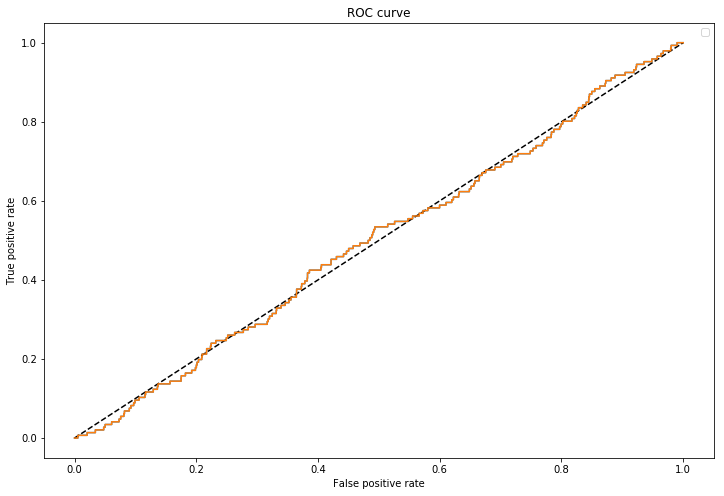

In [0]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Whew, that model _stinks_! Let's train it for more rounds.

In [0]:
train_scores = []
valid_scores = []

for i in range(5):
    print('----- starting round {}'.format(i))
    
    # Re-fit
    model.fit(train, nb_epoch=10)
    
    train_scores.append(model.evaluate(train, [roc_auc_metric]))
    valid_scores.append(model.evaluate(valid, [roc_auc_metric]))

----- starting round 0
computed_metrics: [0.6322356377372538]
computed_metrics: [0.5693936161777788]
----- starting round 1
computed_metrics: [0.7532844158235095]
computed_metrics: [0.7054278545851823]
----- starting round 2
computed_metrics: [0.783983795866963]
computed_metrics: [0.7003528748954604]
----- starting round 3
computed_metrics: [0.8000429962311932]
computed_metrics: [0.693106817121435]
----- starting round 4
computed_metrics: [0.813102997177977]
computed_metrics: [0.7104013326889294]


In [0]:
print(list(d['roc_auc_score'] for d in train_scores))

[0.6322356377372538, 0.7532844158235095, 0.783983795866963, 0.8000429962311932, 0.813102997177977]


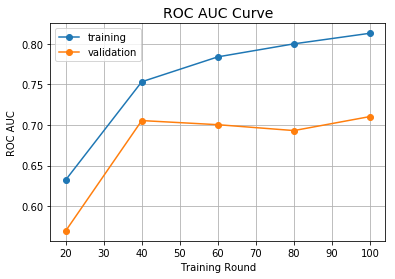

In [0]:
train_scores_v = [d['roc_auc_score'] for d in train_scores]
valid_scores_v = [d['roc_auc_score'] for d in valid_scores]

plt.plot(np.arange(1,len(train_scores_v)+1)*20, train_scores_v, 'o-', label='training')
plt.plot(np.arange(1,len(valid_scores_v)+1)*20, valid_scores_v, 'o-', label='validation')
plt.title('ROC AUC Curve', size=14)
plt.xlabel('Training Round')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid()

We can also plot the confusion matrix to get a sense of how well our model is doing:

In [0]:
y_model = model.predict(test).ravel()
cm = confusion_matrix(test.y, np.round(y_model))
print(cm)

[[33071  1311]
 [   93    53]]


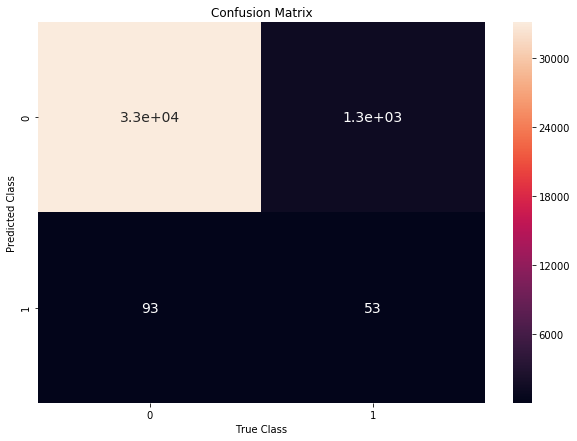

In [0]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,annot_kws={"size": 14})
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix")
plt.show()

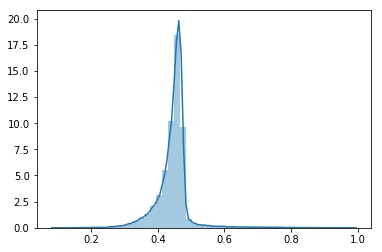

In [0]:
sns.distplot(y_model)

## Interpretation

Following the book's example, we trained the 1D convolution model with 10 epochs, 20 times. So the model sees the data 200 times.

Above, we only run 10 epochs 5 times, so the model sees the data a total of 50 times.

The metric we defined to assess the model was ROC AUC, short for area under the curve (AUC) for the receiver operating characteristic (ROC) curve. This is formed by plotting y (true positive rate) versus x (false positive rate). The more area under the curve, the better the model is at making correct predictions (true positive) versus incorrect predictions (false positives).

More information about the `roc_auc_score` metric can be found in the scikit-learn documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html>

With this in mind, we can see that the model is overfitting the data after around the first 20 training rounds, as the training performance gets better and better while the validation performance levels off.

## Adding Chromatin Data

Next, we expand the model by adding chromatin data.

In [0]:
!ls DeepLearningLifeSciences/Chapter06/

chromatin.txt  tfbinding_chromatin.py  train_siRNA
rnai.py        tfbinding.py	       valid_dataset
test_dataset   train_dataset	       valid_siRNA


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In [0]:
span_accessibility = {}
for line in open('chromatin.txt','r'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

In [0]:
def generate_batches(dataset,epochs):
    for epoch in range(epochs):
        for X, y, w, ids in dataset.iterbatches(batch_size=1000,
                                                pad_batches=True):
            yield {
                'features': X,
                'accessibility': np.array([span_accessibility[id] for id in ids]),
                'labels': y,
                'weights': w
            }

The model is not reset at any point... and if you try and train it, it will use the already-trained model as the starting point... but we changed the architecture... ???

Just rebuild an entirely new model.

In [0]:
model2 = dc.models.TensorGraph(batch_size=1000)
features2 = layers.Feature(shape=(None, 101, 4))
labels2 = layers.Label(shape=(None, 1))
weights2 = layers.Weights(shape=(None, 1))

# Set model architecture: connecting 2 networks together

# Network 1 is the 1D CNN

# Three convolutional layers with identical parameters
prev = features2
convolution_window = 10
for i in range(3):
    prev = layers.Conv1D(filters=15, 
                         kernel_size=convolution_window,
                         activation=tf.nn.relu,
                         padding='same',
                         in_layers=prev)
    prev = layers.Dropout(dropout_prob=0.5, in_layers=prev)

# Previously, we had a dense layer connected to the previous output layer
# This time, we concat previous output layer with accessibility layer,
# followed by the (same) 1-node dense layer

accessibility2 = layers.Feature(shape=(None,1))

prev = layers.Concat([layers.Flatten(prev), accessibility])

logits2 = layers.Dense(out_channels=1, in_layers=layers.Flatten(prev))

# Final prediction
output2 = layers.Sigmoid(logits2)

# Add to model as the output of the model
model2.add_output(output2)

# Loss function:

# Loss function is a combination of layers
# (for stability, use logits instead of output as the input to loss function)
loss2 = layers.SigmoidCrossEntropy(in_layers=[labels2, logits2])

# Combine loss function with weights
weighted_loss2 = layers.WeightedError(in_layers=[loss2, weights2])

# Set as loss function
model2.set_loss(weighted_loss2)

In [0]:
model2.fit_generator(generate_batches(train,10))

0.0

I officially give up on DeepChem, this book is a dumpster fire

In [0]:
model2.evaluate_generator(generate_batches(train,1),
                          [roc_auc_metric],
                          labels=[labels2],
                          weights=[weights2])

Exception in thread Thread-1099:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/site-packages/deepchem/models/tensorgraph/tensor_graph.py", line 1382, in _enqueue_batch
    for feed_dict in generator:
  File "/usr/local/lib/python3.7/site-packages/deepchem/utils/evaluate.py", line 192, in generator_closure
    y.append(feed_dict[self.label_keys[0]])
KeyError: <deepchem.models.tensorgraph.layers.Label object at 0x7f1ca0d5d9e8>



KeyboardInterrupt: ignored